In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
# Define the Grid World environment
class GridWorld:
    def __init__(self):
        """
            0  1  2  3
        0 | 0  0  0  +1
        1 | 0  x  0  -1      x = obstacle
        2 | s  0  0  0       s = agent starting position
        """
        # state: 0=[0,0], 1=[0,1], 2=[0,2], 3=[0,3], 4=[1,0], ..., 10=[2,2], 11=[2,3]
        # action: 0=up, 1=down, 2=left, 3=right

        self.nrows = 12
        self.ncolumns = 12
        self.GOAL_RC = [(10,10)]
        self.TRAP_RC = [(2,9),
                        (4,9),(4,10),
                        (7,10),(8,10),(9,10),(10,8)]
        self.WALL_RC = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11),
                        (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11),
                        (1, 0),(2, 0), (3, 0),(4, 0),(5, 0),(6, 0),(7, 0),(8, 0),(9, 0),(10, 0),
                        (1, 11),(2, 11), (3, 11),(4, 11),(5, 11),(6, 11),(7, 11),(8, 11),(9, 11),(10, 11),

                        (1,4),
                        (2,2),(2,4),(2,6),(2,7),(2,8),
                        (3,7),
                        (4,2),(4,3),(4,5),(4,7),
                        (5,7),
                        (6,1),(6,2),(6,3),(6,4),(6,5),(6,6),(6,7),(6,8),
                        (8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(8,9),
                        (9,2),(9,3),(9,4),(9,5),(9,6)]

        self.rewards = np.zeros((self.nrows, self.ncolumns))
        self.rewards[tuple(zip(*self.GOAL_RC))] = 1 # the goal state, reward = 1
        self.rewards[tuple(zip(*self.TRAP_RC))] = -1 # the lose state, reward = -1
        #start from 0
        self.actions = ['up', 'down', 'left', 'right']
        self.agent_init_pos = [1,1]
        self.agent_pos = self.agent_init_pos  # starting position of the agent

        """opencv"""
        # Maze Map 
        self.BOX_SIZE = 50
        self.BORDER_COLOR = (0,0,0) #black color  
        self.BORDER_THICKENESS = 1
        self.WALL_COLOR = (85,85,85) #grey color  
        self.WALL_THICKNESS = -1
        #trap
        self.TRAP_COLOR = (0,0,255) #red color  
        self.TRAP_THICKNESS = -1
        #goal
        self.GOAL_COLOR = (0,255,0) #green color  
        self.GOAL_THICKNESS = -1
        # Text
        self.TEXT_FONT = cv.FONT_HERSHEY_SIMPLEX
        self.TEXT_SCALE = 0.5
        self.TEXT_COLOR = (0,0,0)
        self.TEXT_THICKNESS = 1
        #robot
        self.AGENT_COLOR = (255, 153, 194)
        self.AGENT_THICKNESS = -1
        
        self.mazeMap = self.createMap() #basic map

    def step(self, action):
        """
        Given an action (0=up, 1=down, 2=left, 3=right),
        return the next valid state index (0~11) and reward R(s,a)
        """
        r, c = self.agent_pos #row, column
        if action == 0:  # move up
            r = max(r - 1, 0)
        elif action == 1:  # move down
            r = min(r + 1, self.nrows-1)
        elif action == 2:  # move left
            c = max(c - 1, 0)
        elif action == 3:  # move right
            c = min(c + 1, self.ncolumns-1)

        if (r,c) not in self.WALL_RC:  # obstacle at [1,1]
            self.agent_pos = [r, c] #agent moved
            reward = 0
        else:
            reward = -0.5#-0.5

        reward += -0.04
        reward += self.rewards[self.agent_pos[0], self.agent_pos[1]]

        #draw robot on new location
        next_scene = self.draw(self.mazeMap.copy(), [(self.agent_pos[1], self.agent_pos[0])], self.AGENT_COLOR, self.AGENT_THICKNESS)

        return self.agentPosIndex(), reward, next_scene

    def isTerminal(self):
        """
        Return True if the agent is at a terminal state
        """
        return tuple(self.agent_pos) in self.GOAL_RC # or self.agent_pos in self.trap_rc

    def reset(self):
        """
        Reset the grid world
        """
        self.agent_pos = self.agent_init_pos  # reset to starting position
        #draw agent's location
        scene = self.draw(self.mazeMap.copy(), [(self.agent_pos[1], self.agent_pos[0])], self.AGENT_COLOR, self.AGENT_THICKNESS)
        return scene

    def agentPosIndex(self):
        """
        Return the current position index (0-11) of the agent in the grid world
        0=[0,0], 1=[0,1], 2=[0,2], 3=[0,3], 4=[1,0], ..., 10=[2,2], 11=[2,3]
        """
        return self.agent_pos[0] * self.nrows + self.agent_pos[1]

    def gridSize(self):
        """
        Return the size of the GridWorld
        """
        return (self.nrows * self.ncolumns)

    def numActions(self):
        """
        Return the number of actions
        """
        return len(self.actions)

    def showGrid(self):
        """
        Display the Grid World
        """
        for i in range(0, self.nrows):
            print('-------------------------------------------------')
            out = '| '
            for j in range(0, self.ncolumns):
                token = ' '
                if (i,j) in self.WALL_RC: # obstacle
                    token = 'X'
                if (i,j) in self.GOAL_RC: # goal state
                    token = 'G'
                if (i,j) in self.TRAP_RC: # lose state
                    token = 'L'
                if i == self.agent_pos[0] and j == self.agent_pos[1]: # agent pos
                    token = '*'

                out += token + ' | '
            print(out)
        print('-------------------------------------------------')

    """opencv"""
    def draw(self, mazeMap, xy, colour, thickness, text=None):
        for y, x in xy:
            top_left = (y * self.BOX_SIZE +2, x * self.BOX_SIZE +2)
            bottom_right = ((y + 1) * self.BOX_SIZE -2, (x + 1) * self.BOX_SIZE -2)
            cv.rectangle(mazeMap, top_left, bottom_right, colour, thickness) 
             
            org_x = top_left[0] + 5 #+ (self.BOX_SIZE)
            org_y = top_left[1] + 20 #+ (self.BOX_SIZE//2)
            
            if text is not None:
                 cv.putText(mazeMap, text, (org_x, org_y), self.TEXT_FONT, self.TEXT_SCALE, self.TEXT_COLOR, self.TEXT_THICKNESS, cv.LINE_AA)
        return mazeMap
    
    def createMap(self):
        """ Create Map for display"""
        # Create a blank white map
        mazeMap = np.ones((self.ncolumns*self.BOX_SIZE, self.nrows*self.BOX_SIZE, 3), dtype=np.uint8)* 255
        
        # draw border
        for row in range(self.nrows):
            for col in range(self.ncolumns):
                top_left = (col * self.BOX_SIZE, row * self.BOX_SIZE)
                bottom_right = ((col + 1) * self.BOX_SIZE, (row + 1) * self.BOX_SIZE)
                cv.rectangle(mazeMap, top_left, bottom_right, self.BORDER_COLOR, self.BORDER_THICKENESS)  
        #draw wall
        mazeMap = self.draw(mazeMap, [(c, r) for r, c in self.WALL_RC], self.WALL_COLOR, self.WALL_THICKNESS)
        #draw trap
        mazeMap = self.draw(mazeMap, [(c, r) for r, c in self.TRAP_RC], self.TRAP_COLOR, self.TRAP_THICKNESS, "-5")
        #draw goal
        mazeMap = self.draw(mazeMap, [(c, r) for r, c in self.GOAL_RC], self.GOAL_COLOR, self.GOAL_THICKNESS, "+10")
        
        return mazeMap

In [2]:
class Controller():
    def __init__(self):
        """Parameter"""
        # Define the color of the arrows (in BGR format)
        self.COLOR_ARROW = (255, 255, 255)
        self.THICKNESS = 2
        self.TIP_LENGTH = 0.5
        self.box_size = 150
        self.RADIUS = 65
        self.CIRCLE_COLOR = (220,220,220) #default colour
        self.CIRCLE_COLOR2 = (255, 204, 204)#pressed colour
        self.CIRCLE_THICKNESS = -1

        # Define start and end points for each arrow direction
        self.start_up = (self.box_size // 2, self.box_size//4 *3) #x,y
        self.end_up = (self.box_size // 2, self.box_size//4)
        self.start_down = self.end_up
        self.end_down = self.start_up
        self.start_right = (self.box_size//4, self.box_size//2)
        self.end_right = (self.box_size//4 *3, self.box_size//2)
        self.start_left = self.end_right
        self.end_left = self.start_right

        # center box
        self.center = (self.box_size // 2, self.box_size // 2)

        # Create boxes for each arrow direction
        self.up_box = np.ones((self.box_size, self.box_size, 3), dtype=np.uint8) * 255
        self.down_box = np.ones((self.box_size, self.box_size, 3), dtype=np.uint8) * 255
        self.left_box = np.ones((self.box_size, self.box_size, 3), dtype=np.uint8) * 255
        self.right_box = np.ones((self.box_size, self.box_size, 3), dtype=np.uint8) * 255

    def step(self, action=None):
        up_box = self.up_box.copy()
        down_box = self.down_box.copy()
        left_box = self.left_box.copy()
        right_box = self.right_box.copy()

        # Draw the circle in the center of the box
        cv.circle(up_box, self.center, self.RADIUS, self.CIRCLE_COLOR, self.CIRCLE_THICKNESS)
        cv.circle(down_box, self.center, self.RADIUS, self.CIRCLE_COLOR, self.CIRCLE_THICKNESS)
        cv.circle(left_box, self.center, self.RADIUS, self.CIRCLE_COLOR, self.CIRCLE_THICKNESS)
        cv.circle(right_box, self.center, self.RADIUS, self.CIRCLE_COLOR, self.CIRCLE_THICKNESS)
        
        if action == 'w' or action == 0:  
            detected_arrow = "Up Arrow"
            cv.circle(up_box, self.center, self.RADIUS, self.CIRCLE_COLOR2, self.CIRCLE_THICKNESS)
        elif action == 's' or action == 1: 
            detected_arrow = "Down Arrow"
            cv.circle(down_box, self.center, self.RADIUS, self.CIRCLE_COLOR2, self.CIRCLE_THICKNESS)
        elif action == 'a' or action == 2: 
            detected_arrow = "Left Arrow"
            cv.circle(left_box, self.center, self.RADIUS, self.CIRCLE_COLOR2, self.CIRCLE_THICKNESS)
        elif action == 'd' or action == 3:  
            detected_arrow = "Right Arrow"
            cv.circle(right_box, self.center, self.RADIUS, self.CIRCLE_COLOR2, self.CIRCLE_THICKNESS)

        # Draw arrowed lines in different directions on the respective boxes
        cv.arrowedLine(up_box, self.start_up, self.end_up, self.COLOR_ARROW, self.THICKNESS, tipLength=self.TIP_LENGTH)  # Up
        cv.arrowedLine(down_box, self.start_down, self.end_down, self.COLOR_ARROW, self.THICKNESS, tipLength=self.TIP_LENGTH)  # Down
        cv.arrowedLine(left_box, self.start_left, self.end_left, self.COLOR_ARROW, self.THICKNESS, tipLength=self.TIP_LENGTH)  # Left
        cv.arrowedLine(right_box, self.start_right, self.end_right, self.COLOR_ARROW, self.THICKNESS, tipLength=self.TIP_LENGTH)  # Right

        # Concatenate the boxes horizontally and vertically
        concatenated_horizontal = np.hstack((up_box, down_box, left_box, right_box))

        return concatenated_horizontal
        

In [3]:
env = GridWorld()
scene = env.reset()
env.showGrid()
cv.imshow("maze", scene)
cv.waitKey(0)
cv.destroyAllWindows()

-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X | * |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   |   |   | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |   |   |   |

In [4]:
env.agent_pos = [7, 8]
next_state, reward, next_scene = env.step(action=0)
print(reward)
print(env.isTerminal())
env.showGrid()

cv.imshow("maze", next_scene)
cv.waitKey(0)
cv.destroyAllWindows()

-0.54
False
-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X |   |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   | * |   | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |

In [5]:
# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.5, gamma=0.9, epsilon=0.5, exploration_proba_decay = 0.08):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.explore_decay = exploration_proba_decay
        # Q-table [n_states, n_actions]
        self.q_table = np.zeros((n_states, n_actions)) # initialized to zeros
        # policy
        self.policy = np.random.randint(n_actions, size=n_states)

    def choose_action(self, state):
        """
        Epsilon-greedy policy: with probability epsilon, choose a random action,
        otherwise choose the action with the highest Q-value for the state
        """
        action = 0
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(self.q_table.shape[1])
        else:
            action = np.argmax(self.q_table[state])
        return action

    def update(self, state, action, reward, next_state):
        """
        Update the Q-value for the (state, action) pair
        """
        self.q_table[state, action] += self.alpha * (reward + self.gamma *
                                                      np.max(self.q_table[next_state]) - self.q_table[state, action])

    def train(self, env, n_episodes=1000, max_steps=1000):
        """
        Train the agent to navigate in the given environment using Q-learning
        """
        print('Training starts...')
        rewards_history = []
        controller = Controller()
        SKIP_FROM = 10 #disable display after episode 10 
        """step 1: initialize Q-table with zeros"""
        self.q_table[:] = 0

        for episode in range(n_episodes):
            scene = env.reset() # reset the environment
            state = env.agentPosIndex()  # starting state
            total_reward = 0
            n_steps = 0
            done = False
            while not done:
                if episode < SKIP_FROM:
                    #display
                    screen = np.vstack((scene, controller.step(None)))
                    cv.imshow('Maze', screen)

                """step 2: choose action for current state"""
                action = self.choose_action(state)

                """step 3: take the action, get the reward and next_state"""
                next_state, reward, next_scene = env.step(action)

                """step 4: update the Q-table"""
                self.update(state, action, reward, next_state)

                """step 5: set state to next_state"""
                state = next_state
                scene = next_scene

                #display
                if episode < SKIP_FROM:
                    screen = np.vstack((scene, controller.step(action)))
                    cv.imshow('Maze', screen)
                    if episode < 1 or episode >600:
                        key = cv.waitKey(50)
                    else:
                        key = cv.waitKey(2)
                """if key & 0xFF == ord('q'):
                    break"""

                # stop if terminal state or n_steps >= max_steps
                n_steps += 1
                total_reward += reward
                if env.isTerminal() or n_steps >= max_steps:
                    print(f'Episode: {episode+1}, Total Reward: {total_reward:.2f},\tEpsilon: {self.epsilon:.2f}, Reached Goal: {env.isTerminal()}')
                    done = True
                if env.isTerminal():
                    self.epsilon = self.epsilon * np.exp(-self.explore_decay)

            rewards_history.append(total_reward)
        cv.destroyAllWindows()
        # generate the optimal policy found after training
        for s in range(self.q_table.shape[0]):
            self.policy[s] = np.argmax(self.q_table[s])

        print('...Training completed!')
        return rewards_history

    def play(self, env, max_steps=100, show_grid=False):
        """
        Play/Test the trained Q-learning agent
        """
        scene = env.reset() # reset to starting state
        state = env.agentPosIndex()
        done = False
        n_steps = 0
        controller = Controller()
        while not done:
            #display
            screen = np.vstack((scene, controller.step(None)))
            cv.imshow('Maze', screen)

            action = self.policy[state]  #or action = np.argmax(self.q_table[state])

            if show_grid:
                env.showGrid()
                print(f'action = {action} ({env.actions[action]})')

            next_state, reward, next_scene = env.step(action)
            state = next_state
            scene = next_scene
            #display
            screen = np.vstack((scene, controller.step(action)))
            cv.imshow('Maze', screen)
            cv.waitKey(50)

            n_steps += 1
            if n_steps > max_steps:
                done = True
                print("Failed to reach goal after", max_steps, "steps!")

            if env.isTerminal():
                done = True
                print(f"Goal reached with {n_steps} steps!")
        cv.destroyAllWindows()

In [6]:
def plot(y,x_label="x", y_label="y", title=None):
    x = list(range(len(y)))

    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if title is None:
        plt.title(y_label + " VS " + x_label)
    else:
        plt.title(title)
    plt.show()

In [7]:
env = GridWorld()
agent = QLearningAgent(env.gridSize(), env.numActions(), alpha=0.5, gamma=0.9, epsilon=0.3, exploration_proba_decay = 0.01)
rewards_history = agent.train(env, n_episodes=700, max_steps=1000)

Training starts...
Episode: 1, Total Reward: -103.04,	Epsilon: 0.30, Reached Goal: True
Episode: 2, Total Reward: -49.60,	Epsilon: 0.30, Reached Goal: True
Episode: 3, Total Reward: -60.68,	Epsilon: 0.29, Reached Goal: True
Episode: 4, Total Reward: -41.34,	Epsilon: 0.29, Reached Goal: True
Episode: 5, Total Reward: -27.92,	Epsilon: 0.29, Reached Goal: True
Episode: 6, Total Reward: -25.84,	Epsilon: 0.29, Reached Goal: True
Episode: 7, Total Reward: -32.88,	Epsilon: 0.28, Reached Goal: True
Episode: 8, Total Reward: -21.14,	Epsilon: 0.28, Reached Goal: True
Episode: 9, Total Reward: -27.88,	Epsilon: 0.28, Reached Goal: True
Episode: 10, Total Reward: -27.64,	Epsilon: 0.27, Reached Goal: True
Episode: 11, Total Reward: -27.94,	Epsilon: 0.27, Reached Goal: True
Episode: 12, Total Reward: -31.06,	Epsilon: 0.27, Reached Goal: True
Episode: 13, Total Reward: -24.02,	Epsilon: 0.27, Reached Goal: True
Episode: 14, Total Reward: -10.68,	Epsilon: 0.26, Reached Goal: True
Episode: 15, Total Rewa

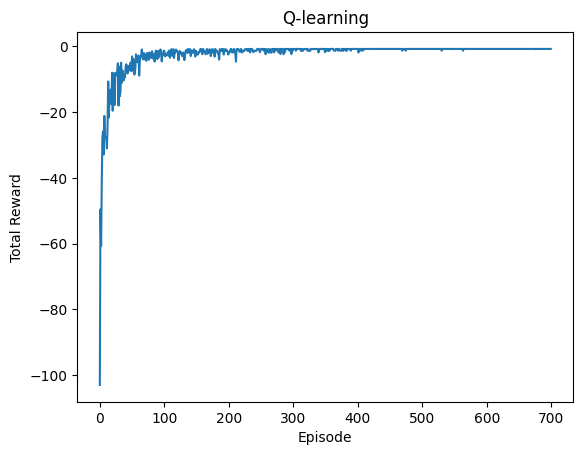

In [8]:
plot(y=rewards_history, x_label="Episode", y_label="Total Reward", title="Q-learning")

In [12]:
# Test the trained Q-learning agent
agent.play(env, max_steps=60, show_grid=True)

-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X | * |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   |   |   | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |   |   |   |